# Module

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import plotly.express as px
import os
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from scipy.spatial.distance import mahalanobis
from sklearn.datasets import load_wine
from matplotlib.colors import ListedColormap

# data

##### z-score

In [3]:
np.random.seed(42)
data = np.random.randn(100, 5)
columns = ['A','B','C','D','E']
df = pd.DataFrame(data, columns = columns)

df.head()

,A,B,C,D,E
0,0.496714,-0.138264,0.647689,1.523030,-0.234153
1,-0.234137,1.579213,0.767435,-0.469474,0.542560
2,-0.463418,-0.465730,0.241962,-1.913280,-1.724918
3,-0.562288,-1.012831,0.314247,-0.908024,-1.412304
4,1.465649,-0.225776,0.067528,-1.424748,-0.544383


In [4]:
means = df.mean()
stds = df.std()

z_scores = (df - means) / stds

threshold = 3 # |z| >= 3 설정

potential_outliers = df[(abs(z_scores) >= threshold).any(axis = 1)]
potential_outliers

,A,B,C,D,E
41,-0.937825,0.515035,0.513786,0.515048,3.852731
52,-0.926930,-0.059525,-3.241267,-1.024388,-0.252568
95,-0.249036,0.576557,0.311250,3.078881,1.119575


##### data

In [7]:
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"

headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
"drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
"num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
"peak-rpm","city-mpg","highway-mpg","price"]

df = pd.read_csv(filename, names = headers)

In [9]:
# data cleaning
df = df.loc[:, ['symboling', 'wheel-base', 'engine-size', 'bore', 'stroke',
'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
'highway-mpg', 'price']]

df = df.replace('?', np.nan)
df = df.dropna()
df.reset_index(drop = True, inplace = True)
df.head()

,symboling,wheel-base,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,88.6,130,3.47,2.68,9.0,111,5000,21,27,13495
1,3,88.6,130,3.47,2.68,9.0,111,5000,21,27,16500
2,1,94.5,152,2.68,3.47,9.0,154,5000,19,26,16500
3,2,99.8,109,3.19,3.40,10.0,102,5500,24,30,13950
4,2,99.4,136,3.19,3.40,8.0,115,5500,18,22,17450


# EDA

In [11]:
y = df['price']
x = df.drop(columns=['price'])

In [13]:
x = sm.add_constant(x)
model = sm.OLS(y.astype(float), x.astype(float)).fit()

np.set_printoptions(suppress=True)
influence = model.get_influence()
cooks = influence.cooks_distance
print(cooks)

(array([0.00005047, 0.00794651, 0.00235295, 0.00115412, 0.00229406,
       0.00001475, 0.00040342, 0.00195747, 0.03696988, 0.00405958,
       0.00509101, 0.00570949, 0.00620111, 0.01803001, 0.00335913,
       0.07252824, 0.02556543, 0.04585015, 0.00000023, 0.00011847,
       0.00000804, 0.00001075, 0.00001616, 0.00002787, 0.00000096,
       0.00017893, 0.00003149, 0.00153593, 0.00321647, 0.05605546,
       0.00023964, 0.0002776 , 0.00017649, 0.00000042, 0.00005717,
       0.00005307, 0.00111793, 0.00011928, 0.00024373, 0.00013439,
       0.00343908, 0.00001979, 0.00038317, 0.00006676, 0.00001466,
       0.01387144, 0.67290488, 0.00029421, 0.00003223, 0.00022211,
       0.00018456, 0.00050611, 0.00026183, 0.00039154, 0.000035  ,
       0.0000165 , 0.00224472, 0.00031293, 0.00134812, 0.01269743,
       0.00220525, 0.01360418, 0.01752224, 0.03048843, 0.00608054,
       0.0820174 , 0.00601548, 0.06747548, 0.00295536, 0.00032691,
       0.00016934, 0.00003394, 0.00003416, 0.00056306, 0.0015

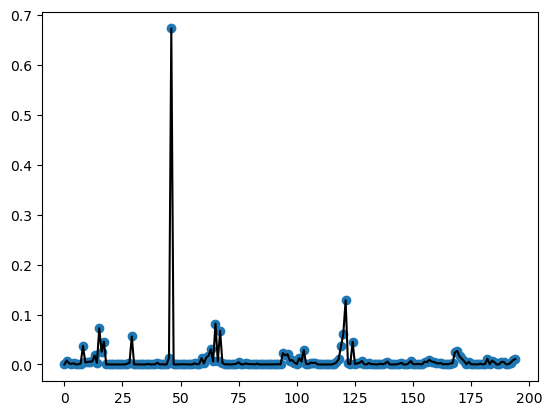

In [21]:
plt.scatter(df.index, cooks[0])
plt.plot(df.index, cooks[0], color = 'black')
plt.show()

mean_cooks: 0.00990911857380291


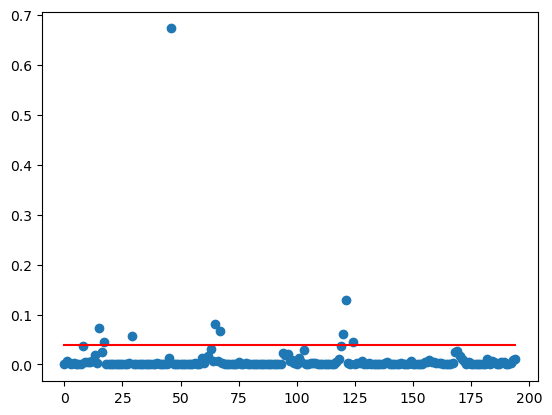

In [27]:
mean_cooks = np.mean(cooks[0])
print(f"mean_cooks: {mean_cooks}")
mean_cooks_list = [4*mean_cooks for cook in df.index]

plt.scatter(df.index, cooks[0])
plt.plot(df.index, mean_cooks_list, color = 'red')
plt.show()

In [28]:
influencial_point = df.index[cooks[0] > 4*mean_cooks]
print(f"Influencial Points index: {influencial_point}")
df.iloc[influencial_point]

Influencial Points index: Index([15, 17, 29, 46, 65, 67, 120, 121, 124], dtype='int64')


,symboling,wheel-base,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
15,0,103.5,209,3.62,3.39,8.0,182,5400,16,22,41315
17,2,88.4,61,2.91,3.03,9.5,48,5100,47,53,5151
29,2,86.6,92,2.91,3.41,9.6,58,4800,49,54,6479
46,0,102.0,326,3.54,2.76,11.5,262,5000,13,17,36000
65,3,96.6,234,3.46,3.10,8.3,155,4750,16,18,35056
67,1,112.0,304,3.80,3.35,8.0,184,4500,14,16,45400
120,3,89.5,194,3.74,2.90,9.5,207,5900,17,25,34028
121,3,89.5,194,3.74,2.90,9.5,207,5900,17,25,37028
124,3,99.1,121,2.54,2.07,9.3,110,5250,21,28,15040


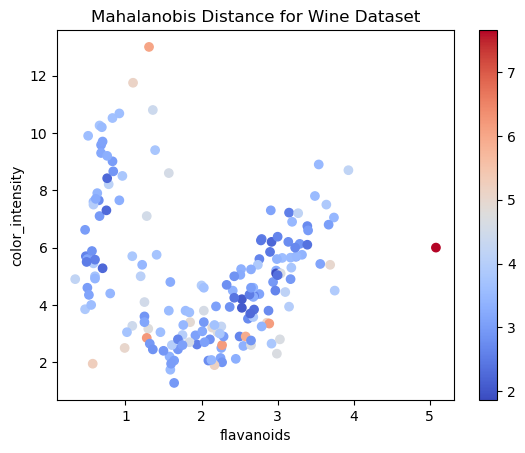

In [38]:
wine = load_wine()
wine_df = pd.DataFrame(wine.data, columns = wine.feature_names)

mean = np.mean(wine_df, axis = 0)
cov = np.cov(wine_df.T)

mahalanobis_dist = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in wine_df.values]

plt.scatter(wine_df['flavanoids'], wine_df['color_intensity'], c=mahalanobis_dist, cmap='coolwarm')
plt.colorbar()
plt.xlabel('flavanoids')
plt.ylabel('color_intensity')
plt.title('Mahalanobis Distance for Wine Dataset')
plt.show()